In [16]:
!pip install -q segmentation-models-pytorch

In [17]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
img_data_path = '/content/drive/MyDrive/datasets/Plant segmentation/images/'
masks_data_path = '/content/drive/MyDrive/datasets/Plant segmentation/masks/'

In [20]:
name = []
for _, _, filenames in os.walk(img_data_path):
    for filename in filenames:
        name.append(filename.split('.')[0])

img_data = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
img_data

,id
0,T02_Box007_2017-09-04T07-12-53-482
1,T02_Box007_2017-09-04T10-46-12-638
2,T02_Box007_2017-09-04T13-12-49-447
3,T02_Box007_2017-09-06T10-42-48-553
4,T02_Box007_2017-09-05T09-21-20-473
...,...
139,T02_Box051_2017-10-27T09-25-38-899
140,T02_Box051_2017-10-26T09-07-39-743
141,T02_Box051_2017-10-30T10-00-27-581
142,T02_Box051_2017-10-29T11-19-23-402


In [21]:
X_traintest, X_val = train_test_split(img_data['id'].values, test_size=0.1)
X_train, X_test = train_test_split(X_traintest, test_size=0.2)
len(X_train), len(X_test), len(X_val)

(103, 26, 15)

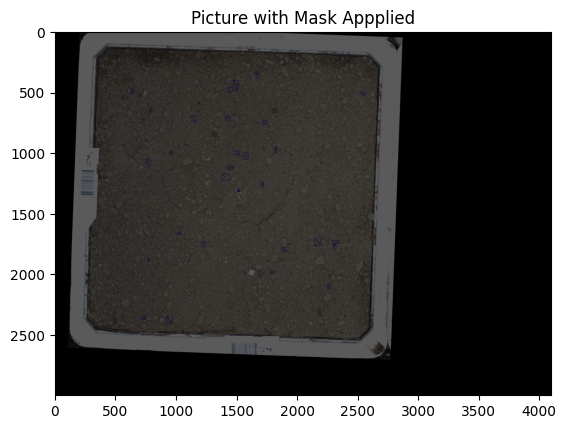

In [22]:
img = Image.open(img_data_path + img_data['id'][2] + '.png')
mask = Image.open(masks_data_path + img_data['id'][2] + '.png')
mask = np.array(mask)
mask[mask != 0] = 1
plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [23]:
class SegDataset(Dataset):
    def __init__(self, img_path, mask_path, df, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.df = df
        self.transform = transform
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.df[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.df[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        mask[mask != 0] = 1

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)

        mask = torch.from_numpy(mask).long()

        return img, mask

In [24]:
t_train = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(),
     ]
)

t_test = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    ]
)

train_dataset = SegDataset(img_data_path, masks_data_path, X_train, t_train)
test_dataset = SegDataset(img_data_path, masks_data_path, X_test, t_test)

In [25]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
model = smp.Unet(
    'mobilenet_v2', encoder_weights='imagenet', classes=2,
    activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


In [27]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [28]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for cl in range(0, n_classes):
            true_class = (pred_mask == cl)
            true_label = (mask == cl)

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [29]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, test_loader, criterion, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)

    for e in range(epochs):
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()

        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            output = model(image)
            loss = criterion(output, mask)

            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()


        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                image_tiles, mask_tiles = data

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                output = model(image)

                val_iou_score +=  mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)

                loss = criterion(output, mask)
                test_loss += loss.item()


            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            val_iou.append(val_iou_score/len(test_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(test_loader))

    history = {
        'train_loss' : train_losses, 'val_loss' : test_losses,
        'train_miou' : train_iou, 'val_miou' : val_iou,
        'train_acc' : train_acc, 'val_acc' : val_acc, 'lrs' : lrs,
        }

    return history

In [30]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
)

history = fit(epoch, model, train_loader, test_loader, criterion, optimizer, sched)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
torch.save(model, 'model.pt')

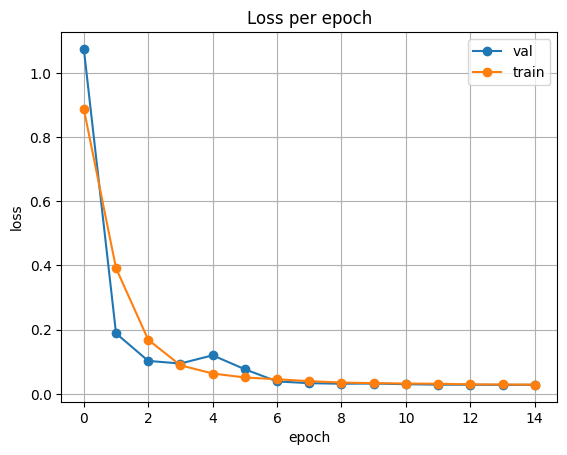

In [32]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot(history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

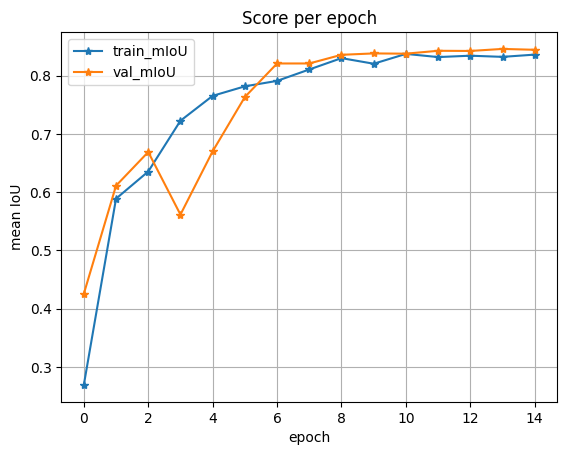

In [33]:
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

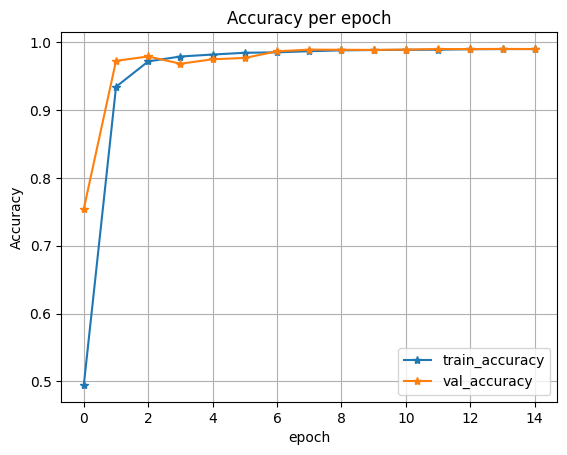

In [34]:
plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

In [35]:
val_dataset = SegDataset(img_data_path, masks_data_path, X_val, t_test)

In [36]:
def process_single_image(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [37]:
def calc_iou_score(model, val_dataset):
    score_iou = []
    for i in tqdm(range(len(val_dataset))):
        img, mask = val_dataset[i]
        pred_mask, score = process_single_image(model, img, mask)
        score_iou.append(score)
    return np.array(score_iou).mean()

In [38]:
calc_iou_score(model, val_dataset)

  0%|          | 0/15 [00:00<?, ?it/s]

0.8293826372446456